1. Leemos todos los archivos bajados de Google business. El dataset es entregado por Soy Henry.

In [4]:
# Librerias Necesarias 
import pandas as pd
import numpy as np
import os
import ast
import re
from unidecode import unidecode
import json


# Los path de los datos
list_sitios_path = [
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\1.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\2.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\3.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\4.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\5.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\6.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\7.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\8.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\9.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\10.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\11.json"
]

2. Sólo guardaremos los datos que son de New Jersey que son el centro de nuestro análisis. Este método de particionamiento resultó muy útil.

In [5]:
import pandas as pd

#Los límites de New Jersey ampliados-- esto luego se hace más preciso con la libreria GeoPandas
NJ_LAT_MIN = 38.8
NJ_LAT_MAX = 41.6
NJ_LON_MIN = -75.7
NJ_LON_MAX = -73.9

for i in range(11):
    df = pd.read_json(list_sitios_path[i], lines=True)
    
    # Filter for NJ locations
    nj_mask = (
        (df['latitude'].between(NJ_LAT_MIN, NJ_LAT_MAX)) & 
        (df['longitude'].between(NJ_LON_MIN, NJ_LON_MAX))
    )
    df = df[nj_mask].copy()
    
    if i == 0:
        google_sitios = df.copy()
    else:
        google_sitios = pd.concat([google_sitios, df], axis=0, ignore_index=True)
    
    del df  # Liberar memoria

# Remover duplicados de gmaps
google_sitios = google_sitios.drop_duplicates(subset=['gmap_id'])

print(f"Se encontró {len(google_sitios)} locaciones únicas en NJ")

Se encontró 186673 locaciones únicas en NJ


3. Buscamos en la lista "Category" cualquier elemento que tenga la palabra "restaurant".

In [6]:
print(type(google_sitios['category'].iloc[0]))  # Dado que es una lista, podemos buscar la palabra restaurant como un elemento de una lista.

<class 'list'>


In [7]:
#Creamos una función de busqueda de la palabra "restaurant"  
def contains_restaurant(categories):
    if not categories or not isinstance(categories, list):
        return False
    return any("restaurant" in str(cat).lower() for cat in categories)


google_restaurantes = google_sitios[google_sitios["category"].apply(contains_restaurant)]

print(f"Se encontro {len(google_restaurantes)} restaurantes en NJ")

Se encontro 19686 restaurantes en NJ


4. Eliminamos los restaurantes que están cerrados

In [8]:
google_restaurantes = google_restaurantes[google_restaurantes["state"] != "Permanently closed"].reset_index(drop=True)

print(f"Se encontró {len(google_restaurantes)} restaurantes abiertos")

Se encontró 14867 restaurantes abiertos


5. Categorizamos los restaurantes con la columna "category_group".

In [9]:
# Mapeo de la categorización- creamos una columna nueva llamada category group.
# Este mapeo fue elaborado con la ayuda de AI... Resultó el mas adecuado de acuerdo a todas las categorias que habian de restaurantes

category_mapping = {
    # Fast Food
    "Hamburger restaurant": "Fast Food",
    "Hot dog restaurant": "Fast Food",
    "Chicken wings restaurant": "Fast Food",
    "Sandwich shop": "Fast Food",
    "Cheesesteak restaurant": "Fast Food",
    "Fast food restaurant": "Fast Food",
    
    # Pizza and Pasta
    "Pizza restaurant": "Pizza and Pasta",
    "Pizza delivery": "Pizza and Pasta",
    "Pizza Takeout": "Pizza and Pasta",
    "Pasta shop": "Pizza and Pasta",
    "Italian restaurant": "Pizza and Pasta",
    
    # Asian Cuisine
    "Chinese restaurant": "Asian Cuisine",
    "Japanese restaurant": "Asian Cuisine",
    "Sushi restaurant": "Asian Cuisine",
    "Ramen restaurant": "Asian Cuisine",
    "Thai restaurant": "Asian Cuisine",
    "Vietnamese restaurant": "Asian Cuisine",
    "Asian fusion restaurant": "Asian Cuisine",
    "Korean restaurant": "Asian Cuisine",
    "Dim sum restaurant": "Asian Cuisine",
    "Noodle shop": "Asian Cuisine",
    
    # Latin & Mexican
    "Mexican restaurant": "Latin & Mexican",
    "Salvadoran restaurant": "Latin & Mexican",
    "Guatemalan restaurant": "Latin & Mexican",
    "Latin American restaurant": "Latin & Mexican",
    "Taco restaurant": "Latin & Mexican",
    "Peruvian restaurant": "Latin & Mexican",
    "Caribbean restaurant": "Latin & Mexican",
    "Puerto Rican restaurant": "Latin & Mexican",
    "Tex-Mex restaurant": "Latin & Mexican",
    
    # Healthy & Specialty Diets
    "Vegan restaurant": "Healthy & Specialty Diets",
    "Vegetarian restaurant": "Healthy & Specialty Diets",
    "Health food restaurant": "Healthy & Specialty Diets",
    "Gluten-free restaurant": "Healthy & Specialty Diets",
    "Kosher restaurant": "Healthy & Specialty Diets",
    "Organic restaurant": "Healthy & Specialty Diets",
    "Salad shop": "Healthy & Specialty Diets",
    
    # Indian & Middle Eastern
    "Indian restaurant": "Indian & Middle Eastern",
    "Pakistani restaurant": "Indian & Middle Eastern",
    "Middle Eastern restaurant": "Indian & Middle Eastern",
    "Mediterranean restaurant": "Indian & Middle Eastern",
    "Shawarma restaurant": "Indian & Middle Eastern",
    "Falafel restaurant": "Indian & Middle Eastern",
    "Halal restaurant": "Indian & Middle Eastern",
    
    # European & Continental
    "Spanish restaurant": "European & Continental",
    "Greek restaurant": "European & Continental",
    "German restaurant": "European & Continental",
    "Irish pub": "European & Continental",
    "Polish restaurant": "European & Continental",
    "Portuguese restaurant": "European & Continental",
    
    # Cafés & Bakeries
    "Coffee shop": "Cafés & Bakeries",
    "Bakery": "Cafés & Bakeries",
    "Bagel shop": "Cafés & Bakeries",
    "Donut shop": "Cafés & Bakeries",
    "Dessert shop": "Cafés & Bakeries",
    "Cake shop": "Cafés & Bakeries",
    "Pretzel store": "Cafés & Bakeries",
    
    # Bars & Pubs
    "Bar": "Bars & Pubs",
    "Pub": "Bars & Pubs",
    "Wine bar": "Bars & Pubs",
    "Karaoke bar": "Bars & Pubs",
    "Sports bar": "Bars & Pubs",
}


#Funcion para limpiar lista de category y luego la mapea con el diccionario creado
def categorize_restaurant_types(categories):
    if not categories or not isinstance(categories, list):
        return 'Other'
    
    for t in categories:
        if t in category_mapping:
            return category_mapping[t]
    return 'Other'



google_restaurantes.loc[:, 'category_group'] = google_restaurantes['category'].apply(categorize_restaurant_types)

print(f"El número de restaurantes que NO están categorizados es de {len(google_restaurantes[google_restaurantes['category_group'] == 'Other'])}")

El número de restaurantes que NO están categorizados es de 4685


6. La categoria "Other" es muy grande y es probable que hayan datos útiles ahi. Para eso, vamos a usar de otra variable que se llama "description" y buscaremos si podemos mapear más restaurantes usando de esta variable. 

In [10]:
# Un mapeo menos estricto
category_mapping_2 = {
    # Fast Food
    "Hamburger": "Fast Food",
    "Hot dog": "Fast Food",
    "Chicken wings": "Fast Food",
    "Sandwich": "Fast Food",
    "Cheesesteak": "Fast Food",
    "Fast food": "Fast Food",
    
    # Pizza and Pasta
    "Pizza": "Pizza and Pasta",
    "Italian": "Pizza and Pasta",
    
    # Asian Cuisine
    "Chinese": "Asian Cuisine",
    "Japanese": "Asian Cuisine",
    "Sushi": "Asian Cuisine",
    "Ramen": "Asian Cuisine",
    "Thai": "Asian Cuisine",
    "Vietnamese": "Asian Cuisine",
    "Asian fusion": "Asian Cuisine",
    "Korean": "Asian Cuisine",
    "Dim sum": "Asian Cuisine",
    "Noodle": "Asian Cuisine",
    
    # Latin & Mexican
    "Mexican": "Latin & Mexican",
    "Salvadoran": "Latin & Mexican",
    "Guatemalan": "Latin & Mexican",
    "Latin American": "Latin & Mexican",
    "Taco": "Latin & Mexican",
    "Peruvian": "Latin & Mexican",
    "Caribbean": "Latin & Mexican",
    "Puerto Rican": "Latin & Mexican",
    "Tex-Mex": "Latin & Mexican",
    
    # Healthy & Specialty Diets
    "Vegan": "Healthy & Specialty Diets",
    "Vegetarian": "Healthy & Specialty Diets",
    "Health food": "Healthy & Specialty Diets",
    "Gluten-free": "Healthy & Specialty Diets",
    "Kosher": "Healthy & Specialty Diets",
    "Organic": "Healthy & Specialty Diets",
    "Salad": "Healthy & Specialty Diets",
    
    # Indian & Middle Eastern
    "Indian": "Indian & Middle Eastern",
    "Pakistani": "Indian & Middle Eastern",
    "Middle Eastern": "Indian & Middle Eastern",
    "Mediterranean": "Indian & Middle Eastern",
    "Shawarma": "Indian & Middle Eastern",
    "Falafel": "Indian & Middle Eastern",
    "Halal": "Indian & Middle Eastern",
    
    # European & Continental
    "Spanish": "European & Continental",
    "Greek": "European & Continental",
    "German": "European & Continental",
    "Irish": "European & Continental",
    "Polish": "European & Continental",
    "Portuguese": "European & Continental",
    
    # Cafés & Bakeries
    "Coffee": "Cafés & Bakeries",
    "Bakery": "Cafés & Bakeries",
    "Bagel": "Cafés & Bakeries",
    "Donut": "Cafés & Bakeries",
    "Dessert": "Cafés & Bakeries",
    "Cake": "Cafés & Bakeries",
    "Pretzel": "Cafés & Bakeries",
    
    # Bars & Pubs
    "Bar": "Bars & Pubs",
    "Pub": "Bars & Pubs",
    "Wine bar": "Bars & Pubs",
    "Karaoke bar": "Bars & Pubs",
    "Sports bar": "Bars & Pubs",
}


In [11]:
# Creamos la función para categorizar
def categorize_description(text):
    matches = []
    if pd.isna(text):
        return matches
    for keyword, category in category_mapping_2.items():
        if keyword.lower() in text.lower():
            matches.append(category)
    return matches


google_restaurantes["category_group_2"] = google_restaurantes["description"].apply(categorize_description)

In [12]:
# Convertir la lista en un string con la primera categoría (si hay al menos una)
google_restaurantes["category_group_2"] = google_restaurantes["category_group_2"].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan
)

#Contamos cuantos "other" hay en la primera categoria y cuantos hay en la segunda.
num_actualizados = ((google_restaurantes["category_group_2"].notna()) &
                    (google_restaurantes["category_group"] == "Other")).sum()

print(f"{num_actualizados} restaurantes fueron actualizados usando la descripción.")

352 restaurantes fueron actualizados usando la descripción.


In [13]:
#Rellenamos en la categoria el Other por la nueva categoria que sacamos de "description"
google_restaurantes.loc[
    (google_restaurantes["category_group"] == "Other") &
    (google_restaurantes["category_group_2"].notna()),
    "category_group"
] = google_restaurantes["category_group_2"]

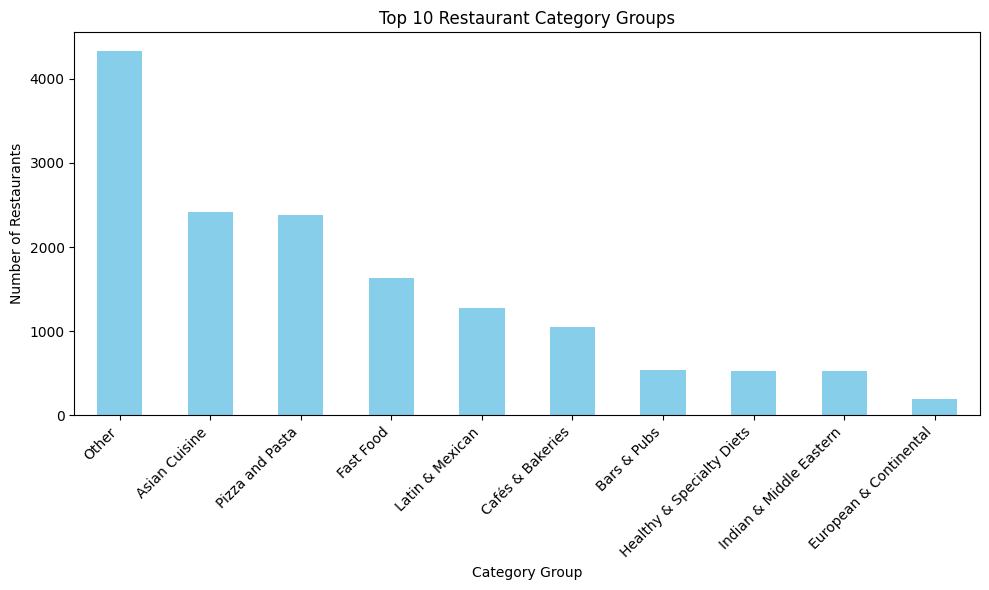

In [14]:
# Seleccionamos el top 4
import matplotlib.pyplot as plt

# Count the frequency of each category group
group_counts = google_restaurantes['category_group'].value_counts().nlargest(10)

# Plot
plt.figure(figsize=(10, 6))
group_counts.plot(kind='bar', color='skyblue')
plt.title('Top 10 Restaurant Category Groups')
plt.xlabel('Category Group')
plt.ylabel('Number of Restaurants')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Al ver este resultado, vamos a usar las top 5 categorias- por que su volumen implica que hay alta demanda en estas categorias.

In [15]:
categorias_a_eliminar = [
    "Other",
    "Bars & Pubs",
    "Indian & Middle Eastern",
    "Healthy & Specialty Diets",
    "European & Continental"
]


google_restaurantes = google_restaurantes[
    ~google_restaurantes["category_group"].isin(categorias_a_eliminar)
]


print(f"Quedan {len(google_restaurantes)} restaurantes después de eliminar las categorías no deseadas.")
print(google_restaurantes["category_group"].value_counts())


Quedan 8743 restaurantes después de eliminar las categorías no deseadas.
category_group
Asian Cuisine       2410
Pizza and Pasta     2375
Fast Food           1632
Latin & Mexican     1278
Cafés & Bakeries    1048
Name: count, dtype: int64


7. Agregamos las variables socio-economicas de Census. El primer paso es crear una variable llamada "County".

In [16]:
import geopandas as gpd
from shapely.geometry import Point

# Cargar todos los counties de EE.UU.
us_counties = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_county_500k.zip")

# Filtrar solo los de New Jersey (FIPS State Code = '34')
nj_counties = us_counties[us_counties['STATEFP'] == '34'].copy()

# Cambiar proyección a una métrica para que el buffer sea en metros (UTM Zone 18N cubre NJ)
nj_counties = nj_counties.to_crs(epsg=26918)

# Ampliar un 10% el tamaño de los polígonos con buffer
nj_counties["geometry"] = nj_counties.geometry.buffer(nj_counties.geometry.area.mean()**0.5 * 0.10)

# Regresar a WGS84 para empatar con los puntos (EPSG:4326)
nj_counties = nj_counties.to_crs(epsg=4326)

# Crear geometrías para restaurantes
geometry = [Point(xy) for xy in zip(google_restaurantes["longitude"], google_restaurantes["latitude"])]
gdf_restaurantes = gpd.GeoDataFrame(google_restaurantes, geometry=geometry, crs="EPSG:4326")

# Cruce espacial con los counties expandidos
restaurantes_con_county = gpd.sjoin(
    gdf_restaurantes,
    nj_counties[["NAME", "geometry"]],
    how="inner",
    predicate="within"
)

# Renombrar columna
restaurantes_con_county = restaurantes_con_county.rename(columns={"NAME": "County"})

print(f"Número de restaurantes dentro del área expandida 10%: {len(restaurantes_con_county)}")


Número de restaurantes dentro del área expandida 10%: 7145


In [17]:
# La lista de los counties encontrados
unique_counties = restaurantes_con_county["County"].dropna().unique().tolist()

print(f"La lista de los counties es:{unique_counties}")

La lista de los counties es:['Hudson', 'Camden', 'Bergen', 'Burlington', 'Essex', 'Union', 'Monmouth', 'Ocean', 'Gloucester', 'Morris', 'Passaic', 'Mercer', 'Middlesex', 'Somerset', 'Sussex', 'Warren', 'Atlantic', 'Cape May', 'Cumberland', 'Salem', 'Hunterdon']


8. Agregamos la información de Census y eliminamos columnas para liberar RAM al momento de sumar las reseñas de Google.

In [18]:
#Abrimos el archivo de CENSUS que tiene variables socio-economicas y que tiene la variable County.
ingresos_nj=pd.read_csv(r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Census-Ingresos NJ.csv")
#Quitamos los problemas de tildes, etc para ambos data frames-
ingresos_nj['County'] = ingresos_nj['County'].apply(lambda x: unidecode(x).upper())

restaurantes_con_county['County'] = restaurantes_con_county['County'].apply(lambda x: unidecode(x).upper())

# Step 2: Agrupamos por la media de County de las variables que nos interesa
ingresos_grouped = ingresos_nj.groupby('County')[[
    'MedianHH_Income',
    'Median_Home_Value',
    'Median_RE_Taxes'
]].mean().reset_index()

# Step 3: Juntamos ambas tablas
google_census = pd.merge(restaurantes_con_county, ingresos_grouped, on='County', how='left')

In [19]:
#Se eliminan las columnas que no se usarán para el analisis.
#Price- tiene muchos nulos y no sirve. Nuestro analisis es por County
google_census.drop(columns=["name","address","description",'latitude','longitude',"price","category","state","relative_results","url","category_group_2","index_right"],inplace=True)
print(f"Los negocios que son para nuestro análisis son {len(google_census)}")

Los negocios que son para nuestro análisis son 7145


9. Al tener los restaurantes de nuestro análisis, juntamos los reviews usando de gmap_id.

In [22]:
# Los path de los datos
list_sitios_path = [
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\review-New_Jersey\1.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\review-New_Jersey\2.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\review-New_Jersey\3.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\review-New_Jersey\4.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\review-New_Jersey\5.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\review-New_Jersey\6.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\review-New_Jersey\7.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\review-New_Jersey\8.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\review-New_Jersey\9.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\review-New_Jersey\10.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\review-New_Jersey\11.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\review-New_Jersey\12.json",
    r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Google\review-New_Jersey\13.json"
]

In [23]:
import json
import pandas as pd

all_reviews = []

for path in list_sitios_path:
    with open(path, encoding='utf-8') as f:
        for i, line in enumerate(f):
            try:
                review = json.loads(line)
                gmap_id = review.get("gmap_id")
                if gmap_id in google_census["gmap_id"].values:
                    all_reviews.append(review)
            except json.JSONDecodeError as e:
                print(f"Error decoding line {i} in {path}: {e}")

# Convertir a DataFrame
reviews_df = pd.DataFrame(all_reviews)

# Combinar con google_census
google_ETL = pd.merge(
    reviews_df,
    google_census,
    how='left',
    on='gmap_id',
    suffixes=('', '_review')
)

print(f"✅ Reviews válidos cargados: {len(reviews_df)}")
print(f"✅ Dimensiones del resultado combinado: {google_ETL.shape}")


✅ Reviews válidos cargados: 222415
✅ Dimensiones del resultado combinado: (333529, 18)


In [ ]:
google_ETL.drop(columns=["pics","resp","time",'name',"geometry"],inplace=True)

10. Llevamos este data frame a un archivo parquet mas sencillo de manejar.

In [ ]:
# Definir la ruta destino
ruta_destino = r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\datos_google_completo.parquet"

# Crear carpeta
os.makedirs(os.path.dirname(ruta_destino), exist_ok=True)

#Guardar en parquet
try:
    google_ETL.to_parquet(ruta_destino, engine='pyarrow')
    print(f"Archivo se guardo exitosamente: {ruta_destino}")
except Exception as e:
    print(f"Error para guardar archivo: {e}")

Archivo se guardo exitosamente: C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\datos_google_completo.parquet
